# Skin Cancer Detection using Cnn

##### By Junaid Babar

##### su92-bscsm-f22-407


### ✅ Step 1: Import Required Libraries & Check GPU


In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ PyTorch version:", torch.__version__)
print("✅ GPU Available:", torch.cuda.is_available())
print("✅ Using Device:", device)

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available")

✅ PyTorch version: 2.5.1+cu118
✅ GPU Available: True
✅ Using Device: cuda
GPU Name: Quadro T1000


### ✅ Step 2: Load Metadata & Image Paths


In [4]:
metadata = pd.read_csv("Dataset/HAM10000_metadata.csv")
image_path_1 = "Dataset/HAM10000_images_part_1"
image_path_2 = "Dataset/HAM10000_images_part_2"

metadata['image_path'] = metadata['image_id'].apply(
    lambda x: os.path.join(image_path_1, f"{x}.jpg") if os.path.exists(os.path.join(image_path_1, f"{x}.jpg"))
    else os.path.join(image_path_2, f"{x}.jpg")
)

label_mapping = {label: idx for idx, label in enumerate(metadata['dx'].unique())}
metadata['label'] = metadata['dx'].map(label_mapping)

print("✅ Total images found:", len(metadata))
print("✅ Labels mapped:", label_mapping)


### ✅ Step 3: Split Dataset
train_df, test_df = train_test_split(metadata, test_size=0.2, stratify=metadata['label'], random_state=42)
print("✅ Training samples:", len(train_df))
print("✅ Testing samples:", len(test_df))

✅ Total images found: 10015
✅ Labels mapped: {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}
✅ Training samples: 8012
✅ Testing samples: 2003


### ✅ Step 3: Split Dataset


In [5]:
train_df, test_df = train_test_split(metadata, test_size=0.2, stratify=metadata['label'], random_state=42)
print("✅ Training samples:", len(train_df))
print("✅ Testing samples:", len(test_df))

✅ Training samples: 8012
✅ Testing samples: 2003


### ✅ Step 4: Custom Dataset Class


In [6]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'image_path']
        image = Image.open(img_path).convert("RGB")
        label = self.dataframe.loc[idx, 'label']

        if self.transform:
            image = self.transform(image)

        return image, label

### ✅ Step 5: Transforms and Dataloaders


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Replace with original size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = SkinCancerDataset(train_df, transform=transform)
test_dataset = SkinCancerDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("✅ DataLoaders are ready")

✅ DataLoaders are ready


### ✅ Step 6: CNN Model Definition


In [9]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # Input channels = 3 (RGB), Output channels = 32
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces size by half

            nn.Conv2d(32, 64, 3, padding=1),  # Input channels = 32, Output channels = 64
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces size by half

            nn.Conv2d(64, 128, 3, padding=1),  # Input channels = 64, Output channels = 128
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces size by half

            nn.Flatten(),  # Flatten the output for the fully connected layer
            nn.Linear(28 * 28 * 128, 512),  # Adjust input size based on new image size
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 7)  # Output size = 7 (number of classes)
        )

    def forward(self, x):
        return self.net(x)

model = CNNModel().to(device)
print("✅ CNN Model updated and loaded")

✅ CNN Model updated and loaded


### ✅ Step 7: Loss, Optimizer, Scheduler


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


### ✅ Step 8: Training and Validation Loop


In [12]:
train_acc, val_acc = [], []
epochs = 25

for epoch in range(epochs):
    print(f"🔄 Starting Epoch {epoch + 1}/{epochs}...")
    
    # Training phase
    model.train()
    correct, total, loss_sum = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loss_sum += loss.item()

    acc = correct / total
    train_acc.append(acc)
    print(f"✅ Training completed for Epoch {epoch + 1}. Accuracy: {acc:.4f}, Loss: {loss_sum:.4f}")

    # Validation phase
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    val_acc.append(val_accuracy)
    scheduler.step()
    print(f"✅ Validation completed for Epoch {epoch + 1}. Validation Accuracy: {val_accuracy:.4f}")

    print(f"📊 Epoch {epoch + 1}/{epochs} Summary: Train Acc: {acc:.4f}, Val Acc: {val_accuracy:.4f}, Images Trained: {total}")

print("🎉 Training and validation completed for all epochs!")

🔄 Starting Epoch 1/25...
✅ Training completed for Epoch 1. Accuracy: 0.6931, Loss: 420.1978
✅ Validation completed for Epoch 1. Validation Accuracy: 0.7169
📊 Epoch 1/25 Summary: Train Acc: 0.6931, Val Acc: 0.7169, Images Trained: 8012
🔄 Starting Epoch 2/25...
✅ Training completed for Epoch 2. Accuracy: 0.7152, Loss: 382.9635
✅ Validation completed for Epoch 2. Validation Accuracy: 0.7279
📊 Epoch 2/25 Summary: Train Acc: 0.7152, Val Acc: 0.7279, Images Trained: 8012
🔄 Starting Epoch 3/25...
✅ Training completed for Epoch 3. Accuracy: 0.7298, Loss: 364.6227
✅ Validation completed for Epoch 3. Validation Accuracy: 0.7439
📊 Epoch 3/25 Summary: Train Acc: 0.7298, Val Acc: 0.7439, Images Trained: 8012
🔄 Starting Epoch 4/25...
✅ Training completed for Epoch 4. Accuracy: 0.7400, Loss: 345.5120
✅ Validation completed for Epoch 4. Validation Accuracy: 0.7454
📊 Epoch 4/25 Summary: Train Acc: 0.7400, Val Acc: 0.7454, Images Trained: 8012
🔄 Starting Epoch 5/25...
✅ Training completed for Epoch 5. A

### ✅ Step 9: Plot Accuracy Curves


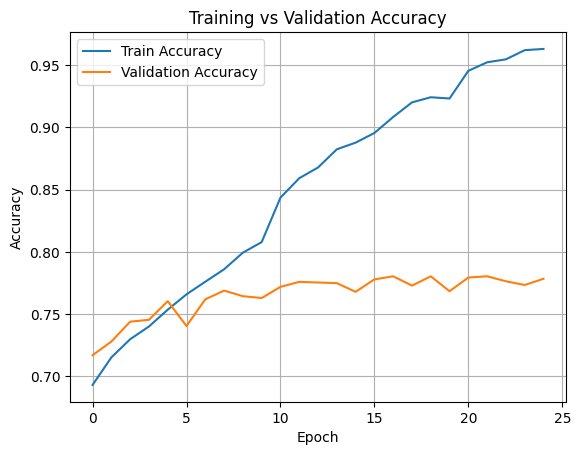

In [13]:
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

### ✅ Step 10: Save Model and Predictions


In [14]:
# Save the model
model_path = os.path.abspath('skin_cancer_cnn_model.pth')
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to disk at: {model_path}")

✅ Model saved to disk at: e:\AI\Envs\pytorch_env\skin_cancer_cnn_model.pth


In [15]:
# Export predictions
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.numpy())

# Save predictions to CSV
results_df = pd.DataFrame({'True Label': true_labels, 'Predicted Label': predictions})
results_df.to_csv("predictions.csv", index=False)
print("✅ Predictions exported to predictions.csv")


✅ Predictions exported to predictions.csv
